In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#8.5-적대적-생성-신경망(GAN)-소개" data-toc-modified-id="8.5-적대적-생성-신경망(GAN)-소개-1">8.5 적대적 생성 신경망(GAN) 소개</a></span><ul class="toc-item"><li><span><a href="#8.5.1-GAN-구현-방법" data-toc-modified-id="8.5.1-GAN-구현-방법-1.1">8.5.1 GAN 구현 방법</a></span></li><li><span><a href="#8.5.2-훈련-방법" data-toc-modified-id="8.5.2-훈련-방법-1.2">8.5.2 훈련 방법</a></span></li><li><span><a href="#8.5.3-생성자(Generator)" data-toc-modified-id="8.5.3-생성자(Generator)-1.3">8.5.3 생성자(Generator)</a></span></li><li><span><a href="#8.5.4-판별자(Discriminator)" data-toc-modified-id="8.5.4-판별자(Discriminator)-1.4">8.5.4 판별자(Discriminator)</a></span></li><li><span><a href="#8.5.5-GAN" data-toc-modified-id="8.5.5-GAN-1.5">8.5.5 GAN</a></span></li><li><span><a href="#8.5.6-DCGAN-훈련방법" data-toc-modified-id="8.5.6-DCGAN-훈련방법-1.6">8.5.6 DCGAN 훈련방법</a></span></li><li><span><a href="#8.5.7-정리" data-toc-modified-id="8.5.7-정리-1.7">8.5.7 정리</a></span></li></ul></li></ul></div>

## 8.5 적대적 생성 신경망(GAN) 소개


- **GAN**은 VAE와 다른 방법으로 이미지의 잠재공간(latent space)을 학습한다.
- GAN은 생성된 이미지가 실제 이미지와 통계적으로 거의 구분이 되지 않도록 강제하여 실제 같은 합성 이미지를 생성한다.
- GAN은 두 개의 네트워크를 가지는데, 다음과 같다.
    - **generator network**: 랜덤 벡터(잠재 공간의 무작위한 포인트)를 입력으로 받아 이를 합성된 이미디로 디코딩한다.
    - **discriminator network**: 이미지(실제 또는 합성)를 입력으로 받아 훈련세트에서 온 이미지인지, generator에서 만든 이미지인지 판별한다.
    

![](./images/gan01.png)

- generator는 discriminator를 속이도록 훈련한다.
- 훈련이 계속 될수록 점점 더 실제와 같은 이지를 생성하게 된다.
- VAE와 달리 GAN의 잠재공간은 연속적이지 않으며, 의미있는 구조를 보장하지 않는다.

![](./images/gan02.png)

- GAN은 손실함수의 최소값을 찾는 최적화 과정이 아니라 두 네트워크(generator, discriminator)간의 평형점을 찾는 과정이라 할 수 있다.

### 8.5.1 GAN 구현 방법

이 절에서는 케라스에서 가장 기본적인 형태의 GAN을 구현하는 방법을 설명하겠습니다. GAN은 수준 높은 기술이기 때문에 기술적인 내용을 깊이 설명하는 것은 이 책의 범위를 벗어납니다. 

구체적인 구현은 **심층 합성곱 GAN(DCGAN)**입니다. 생성자와 판별자가 **심층 컨브넷**입니다. 특히 생성자에서 이미지 업샘플링을 위해 `Conv2DTranspose` 층을 사용합니다.

CIFAR10 데이터셋의 이미지로 GAN을 훈련하겠습니다. 이 데이터셋은 `32 × 32` 크기의 RGB 이미지 50,000개로 이루어져 있고 10개의 클래스를 가집니다(클래스마다 5,000개의 이미지가 있습니다). 문제를 간단하게 만들기 위해 “frog” 클래스의 이미지만 사용하겠습니다.

![](./images/dcgan.png)

GAN 구조는 다음과 같습니다:

1. `generator` 네트워크는 `(latent_dim,)` 크기의 벡터를 `(32, 32, 3)` 크기의 이미지로 매핑합니다.
2. `discriminator` 네트워크는 `(32, 32, 3)` 크기의 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑합니다.
3. 생성자와 판별자를 연결하는 `gan` 네트워크를 만듭니다. `gan(x) = discriminator(generator(x))` 입니다. 이 `gan` 네트워크는 잠재 공간의 벡터를 판별자의 평가로 매핑합니다. 판별자는 생성자가 잠재 공간의 벡터를 디코딩한 것이 얼마나 현실적인지를 평가합니다.
4. 진짜"/”가짜" 레이블과 함께 진짜 이미지와 가짜 이미지 샘플을 사용해 판별자를 훈련합니다. 일반적인 이미지 분류 모델을 훈련하는 것과 동일합니다.
5. 생성자를 훈련하려면 `gan` 모델의 손실에 대한 생성자 가중치의 그래디언트를 사용합니다. 이 말은 매 단계마다 생성자에 의해 디코딩된 이미지를 판별자가 “진짜"로 분류하도록 만드는 방향으로 생성자의 가중치를 이동한다는 뜻입니다. 다른 말로하면 판별자를 속이도록 생성자를 훈련합니다.

### 8.5.2 훈련 방법

GAN을 훈련하고 튜닝하는 과정은 어렵기로 유명합니다. 알아두어야 할 몇 가지 유용한 기법이 있습니다. 딥러닝의 대부분이 그렇듯이 이는 과학보다는 연금술에 가깝습니다. 이런 기법들은 이론에 바탕을 둔 지침이 아니고 경험을 통해 발견된 것입니다. 실제 일어난 현상을 직관적으로 이해하는 수준에서 검증되었습니다. 모든 문제에 반드시 적용해야 것은 아니지만 경험상 잘 작동한다고 알려져 있습니다.

다음은 이 절에서 GAN 생성자와 판별자를 구현하는 데 사용할 몇 가지 기법입니다. 이 목록이 GAN에 관련된 전체 팁이 아닙니다. GAN 논문들에서 더 많은 방법을 볼 수 있습니다.

- 생성자의 마지막 활성화로 다른 종류의 모델에서 널리 사용하는 `sigmoid` 대신 `tanh` 함수를 사용합니다.
- 균등 분포가 아니고 정규 분포(가우시안 분포)를 사용하여 잠재 공간에서 포인트를 샘플링합니다.
- **무작위성은 모델을 견고하게 만듭니다**. GAN 훈련은 동적 평형을 만들기 때문에 여러 방식으로 갇힐 가능성이 높습니다. 훈련하는 동안 무작위성을 주입하면 이를 방지하는 데 도움이 됩니다. 무작위성은 두 가지 방법으로 주입합니다. **판별자에 드롭아웃**을 사용하거나 **판별자를 위해 레이블에 랜덤 노이즈를 추가**합니다.
- 희소한 그래디언트는 GAN 훈련을 방해할 수 있습니다. 딥러닝에서 희소는 종종 바람직한 현상이지만 GAN에서는 그렇지 않습니다. 그래디언트를 희소하게 만들 수 있는 것은 최대 풀링 연산과 ReLU 활성화 두 가지입니다. 최대 풀링 대신 스트라이드 합성곱을 사용해 다운샘플링을 하는 것이 좋습니다. 또 ReLU 활성화 대신 LeakyReLU 층을 사용하세요. ReLU와 비슷하지만 음수의 활성화 값을 조금 허용하기 때문에 희소가 조금 완화됩니다.
- 생성자에서 픽셀 공간을 균일하게 다루지 못해 생성된 이미지에서 체스판 모양이 종종 나타납니다(그림 8-17 참조). 이를 해결하기 위해 생성자와 판별자에서 스트라이드 `Conv2DTranpose`나 `Conv2D`를 사용할 때 스트라이드 크기로 나누어질 수 있는 커널 크기를 사용합니다.

### 8.5.3 생성자(Generator)

먼저 벡터(훈련하는 동안 잠재 공간에서 무작위로 샘플링됩니다)를 후보 이미지로 변환하는 `generator` 모델을 만들어 보죠. 
- GAN에서 발생하는 많은 문제 중 하나는 생성자가 노이즈 같은 이미지를 생성하는 데서 멈추는 것입니다. 
- 판별자와 생성자 양쪽에 모두 드롭아웃을 사용하는 것이 해결 방법이 될 수 있습니다.

In [1]:
import keras
import numpy as np
from keras import layers, models

Using TensorFlow backend.


In [2]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 x 16 크기의 128개 채널을 가진 특성 맵으로 변환한다.
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# 합성곱 층을 추가
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 × 32 크기로 업샘플링합니다
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# 합성곱 층을 더 추가한다.
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 32 x 32 크기의 3개 채널을 가진 특성 맵을 생성한다.
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = models.Model(generator_input, x, name='generator')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [3]:
# from IPython.display import Image
# from keras.utils import plot_model

# plot_model(generator, to_file='./plot-model/dcgan-generator.png')
# Image(filename='./plot-model/dcgan-generator.png')

### 8.5.4 판별자(Discriminator)

다음은 후보 이미지(진짜 혹은 가짜)를 입력으로 받고 두 개의 클래스로 분류하는 `discriminator` 모델을 만들겠습니다. 이 클래스는 '생성된 이미지' 또는 '훈련 세트에서 온 진짜 이미지'입니다.

In [4]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 드롭아웃 층을 넣는 것이 중요하다!
x = layers.Dropout(0.4)(x)

# 분류 층
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = models.Model(discriminator_input, x, name='disrciminator')
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용한다.
# 안정된 훈련을 위해서 학습률 감쇠(learning rate decay)를 사용한다.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, 
                                                   clipvalue=1.0,
                                                   decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,
                      loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

In [5]:
# from IPython.display import Image
# from keras.utils import plot_model

# plot_model(discriminator, to_file='./plot-model/dcgan-discriminator.png')
# Image(filename='./plot-model/dcgan-discriminator.png')

### 8.5.5 GAN

마지막으로 생성자와 판별자를 연결하여 GAN을 설정합니다. 
- 훈련할 때 생성자가 판별자를 속이는 능력이 커지도록 학습합니다. 
- 이 모델은 잠재 공간의 포인트를 “진짜" 또는 “가짜"의 분류 결정으로 변환합니다. 
- 훈련에 사용되는 타깃 레이블은 항상 '진짜 이미지'입니다. 
- gan을 훈련하는 것은 `discriminator`가 가짜 이미지를 보았을 때 진짜라고 예측하도록 만들기 위해 `generator`의 가중치를 업데이트하는 것입니다. 
- **훈련하는 동안 판별자를 동결(학습되지 않도록)하는 것이 아주 중요**합니다. 
    - gan을 훈련할 때 가중치가 업데이트되지 않습니다. 판별자의 가중치가 훈련하는 동안 업데이트되면 판별자는 항상 “진짜"를 예측하도록 훈련됩니다. 이것이 우리가 원하는 바는 아니죠!

In [6]:
# 판별자의 가중치가 훈련된지 않도록 설정한다.(gan 모델에만 적용)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output, name='gan')
gan.summary()

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32)                0         
_________________________________________________________________
generator (Model)            (None, 32, 32, 3)         6264579   
_________________________________________________________________
disrciminator (Model)        (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [7]:
# from IPython.display import Image
# from keras.utils import plot_model

# plot_model(gan, to_file='./plot-model/dcgan.png')
# Image(filename='./plot-model/dcgan.png')

### 8.5.6 DCGAN 훈련방법

이제 훈련을 시작합니다. 훈련 반복의 내용을 요약 정리해 보겠습니다.

매 반복마다 다음을 수행합니다:

1. 잠재 공간에서 무작위로 포인트를 뽑습니다(랜덤 노이즈).
2. 이 랜덤 노이즈를 사용해 `generator`에서 이미지를 생성합니다.
3. 생성된 이미지와 진짜 이미지를 섞습니다.
4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타깃을 사용해 `discriminator`를 훈련합니다. 타깃은 “진짜"(실제 이미지일 경우) 또는 “가짜"(생성된 이미지일 경우)입니다.
5. 잠재 공간에서 무작위로 새로운 포인트를 뽑습니다.
6. 이 랜덤 벡터를 사용해 `gan`을 훈련합니다. 모든 타깃은 “진짜"로 설정합니다. 판별자가 생성된 이미지를 모두 “진짜 이미지"라고 예측하도록 생성자의 가중치를 업데이트합니다(`gan` 안에서 판별자는 동결되기 때문에 생성자만 업데이트합니다). 결국 생성자는 판별자를 속이도록 훈련합니다.

In [8]:
import os 
from keras.preprocessing import image

In [9]:
# CIFAR10 데이터를 로드한다.
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [10]:
# CIFAR10 데이터를 로드한다.
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 개구리 이미지를 선택한다.(클래스 6)
x_train = x_train[y_train.flatten() == 6]

# 데이터를 정규화한다.
x_train = x_train.reshape(  # (50000, 32, 32, 3)
    (x_train.shape[0],) + (height, width, channels)).astype('float32')/255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
# 훈련 반복 시작
start = 0
for step in range(iterations):
    # 잠재 공간에서 무작위로 포인트를 샘플링한다.
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 가짜 이미지를 디코딩한다.
    generated_images = generator.predict(random_latent_vectors)
    
    # 진짜 이미지와 연결한다.
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    # 진짜와 가짜 이미지를 구분하여 레이블을 합친다.
    labels = np.concatenate([np.ones((batch_size, 1)), 
                             np.zeros((batch_size, 1))])
    # 레이블에 랜덤 노이즈를 추가한다 → 매우 중요하다!
    labels += 0.05 * np.random.random(labels.shape)
    
    # discriminator를 훈련한다.
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # 잠재 공간에서 무작위로 포인트를 샘플링한다.
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # 모두 "진짜 이미지"라고 레이블을 만든다.
    misleading_targets = np.zeros((batch_size, 1))
    
    # generator를 훈련한다.(gan 모델에서 discriminator의 가중치는 동결된다.)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    # 중간 중간 저장하고 그래프를 그린다.
    if step % 100 == 0:
        # 모델의 가중치를 저장
        gan.save_weights('./models/gan.h5')
        
        # 측정 지표를 출력한다.
        print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
        print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))
        
        # 생성된 이미지 하나를 저장한다.
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog'+str(step)+'.png'))
        
        # 비교를 위해 진짜 이미지 하나를 저장한다.
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog'+str(step)+'.png'))

F:\miniconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


스텝 0에서 판별자 손실: 0.68601674
스텝 0에서 적대적 손실: 0.6835162
스텝 100에서 판별자 손실: 0.67390424
스텝 100에서 적대적 손실: 0.9120716
스텝 200에서 판별자 손실: 0.682351
스텝 200에서 적대적 손실: 0.74963367
스텝 300에서 판별자 손실: 0.71728134
스텝 300에서 적대적 손실: 0.7820779
스텝 400에서 판별자 손실: 1.072718
스텝 400에서 적대적 손실: 0.7614701
스텝 500에서 판별자 손실: 0.69702214
스텝 500에서 적대적 손실: 0.7845014
스텝 600에서 판별자 손실: 0.70103854
스텝 600에서 적대적 손실: 0.8046153
스텝 700에서 판별자 손실: 0.70623535
스텝 700에서 적대적 손실: 0.8121726
스텝 800에서 판별자 손실: 0.6981317
스텝 800에서 적대적 손실: 0.74482346
스텝 900에서 판별자 손실: 0.7002711
스텝 900에서 적대적 손실: 0.7584585
스텝 1000에서 판별자 손실: 0.72050464
스텝 1000에서 적대적 손실: 0.7215841
스텝 1100에서 판별자 손실: 0.6937747
스텝 1100에서 적대적 손실: 1.040402
스텝 1200에서 판별자 손실: 0.7119692
스텝 1200에서 적대적 손실: 0.7712651
스텝 1300에서 판별자 손실: 0.7051045
스텝 1300에서 적대적 손실: 0.7379454
스텝 1400에서 판별자 손실: 0.69827664
스텝 1400에서 적대적 손실: 0.7500836
스텝 1500에서 판별자 손실: 0.689908
스텝 1500에서 적대적 손실: 0.753253
스텝 1600에서 판별자 손실: 0.6886414
스텝 1600에서 적대적 손실: 0.74378157
스텝 1700에서 판별자 손실: 0.6929329
스텝 1700에서 적대적 손실: 0.7556578
스텝 1800에서 

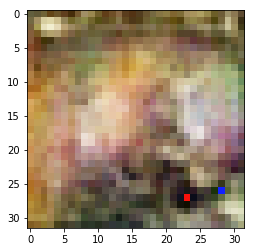

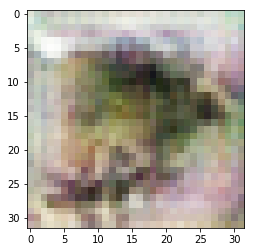

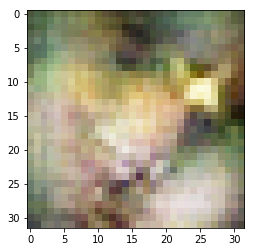

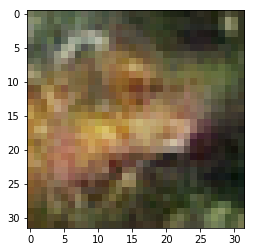

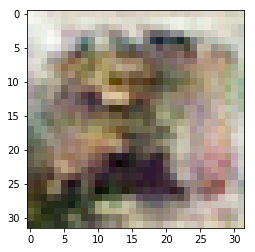

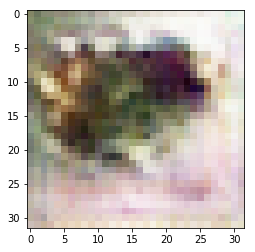

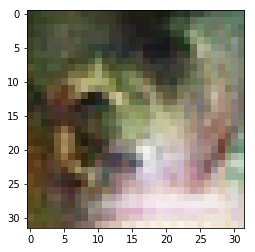

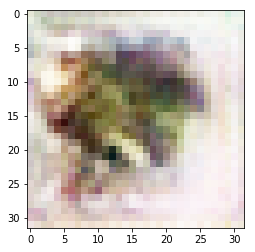

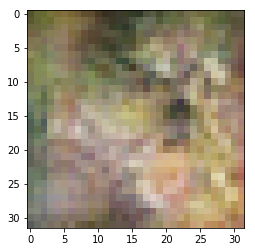

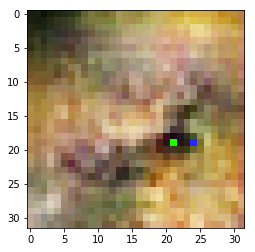

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# 잠재 공간에서 랜덤한 포인트를 샘플링합니다
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# 가짜 이미지로 디코딩합니다
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

### 8.5.7 정리

- GAN은 생성자(generator)네트워크와 판별자(discriminator) 네트워크가 연결되어 구성된다.
    - 판별자는 생성자의 출력과 훈련 데이터셋에서 가져온 진짜 이미지를 구분하도록 훈련된다. 생성자는 판별자를 속이도록 훈련된다.
    - 생성자는 훈련 세트의 이미지를 직접 보지않고, 데이터에 관한 정보는 판별자에서 얻는다.
    
- GAN은 훈련하기 어렵다. GAN 훈련이 고정된 손실 공간에서 수행하는 단순한 경사하상법 과정이 아니라 동적 과정이기 때문이다.
- GAN은 실제 같은 이미지를 만들 수 있다. VAE와 달리 학습된 잠재공간이 깔끔하게 연속된 구조를 가지지 않는다.